In [7]:
# !pip install dimod
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scipy
# !pip install plotly
# !pip install --upgrade nbformat # nbformat version issue fix for plotly.


# Global Appliance Optimization

## Phase 1: Setup, Data Loading, and Parameter Definition.
This code will import our libraries, load the smart_grid_dataset_2024.csv file, and set up all the "Given" parameters from our problem. This cell is almost identical to the original, just with the PennyLane/JAX imports removed.

In [2]:
# Step 1: Setup, Data Loading, and Parameter Definition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
def warn (*args, **kwargs):
    pass
import warnings
warnings.filterwarnings('ignore')

print("Phase 1: Setup & Data Preparation")

#  1. Load Data 
try:
    df = pd.read_csv("smart_grid_dataset_2024.csv")
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
except FileNotFoundError:
    print("ERROR: 'smart_grid_dataset_2024.csv' not found.")
    # In a real notebook, we'd stop execution here

#  2. Create Time-Series Arrays (The "Givens") 
# Filter for our 24-hour period (Jan 1, 2024)
df_24h = df[df['Timestamp'].dt.date == pd.to_datetime('2024-01-01').date()].copy()

if len(df_24h) != 96:
    print(f"Warning: Expected 96 time steps, but found {len(df_24h)}.")

# Total time steps (T = 96)
T = len(df_24h) 

# B_t: Baseline Load (kW)
B_t = df_24h['Power Consumption (kW)'].values

# C_t: Energy Price (USD/kWh)
C_t = df_24h['Electricity Price (USD/kWh)'].values

# R_t: Renewable Production (kW)
R_t = (df_24h['Solar Power (kW)'] + df_24h['Wind Power (kW)']).values

print(f"Data loaded for {T} time steps.")

# 3. Define Appliance Parameters (The "Problem Space") 
# --- THIS IS THE UPDATED (UN-PRUNED) SECTION ---
# We are now using all valid 15-minute start times.

print("Using FULL Appliance Parameters (for 101 variables)")

appliances = {
    'ev_charger': {
        'P': 9.0,  # kW
        'L': 16,   # 16 steps = 4 hours
        # Window: 10:00 PM (88) to 6:00 AM (ends at step 23)
        'window': list(range(88, 96)) + list(range(0, 24 - 16 + 1)) 
    },
    'washing_machine': {
        'P': 1.5,  # kW
        'L': 4,    # 4 steps = 1 hour
        # Window: 8:00 AM (32) to 10:00 PM (ends at step 87)
        'window': list(range(32, 88 - 4 + 1))
    },
    'dishwasher': {
        'P': 1.8,  # kW
        'L': 6,    # 6 steps = 1.5 hours
        # Window: 8:00 PM (80) to 5:00 AM (ends at step 19)
        'window': list(range(80, 96)) + list(range(0, 20 - 6 + 1))
    }
}

print("Appliance parameters (full) are now defined.")
print("Phase 1 Complete \n")

Phase 1: Setup & Data Preparation
Data loaded for 96 time steps.
Using FULL Appliance Parameters (for 101 variables)
Appliance parameters (full) are now defined.
Phase 1 Complete 



## Phase 2: Building the QUBO
This is the main change. Instead of building an Ising Hamiltonian ($H$) for QAOA, we will build the QUBO matrix ($Q$) directly. The objective function is: $E(x) = \sum_i Q_{i,i} x_i + \sum_{i<j} Q_{i,j} x_i x_j$ We will build the $Q$ dictionary, which dimod (D-Wave's library) understands.

In [4]:
import dimod

print("\n Phase 2: Building the QUBO \n")

#  4. Define Variable Mapping (Decision Variables) 
# We map each possible start time for each appliance to a unique variable index.
# x_{i,t} -> var_index

var_map = {} # {('appliance_name', start_time): var_index}
reverse_map = {} # {var_index: ('appliance_name', start_time)}
current_var_index = 0

for app_name, details in appliances.items():
    for start_time in details['window']:
        var_map[(app_name, start_time)] = current_var_index
        reverse_map[current_var_index] = (app_name, start_time)
        current_var_index += 1

n_vars = len(var_map)
print(f"Total number of decision variables: {n_vars}")

# --- 5. Define Hyperparameters (A, B, C) ---\
# These are the weights for our objective function
A = 0.5  # Weight for Cost
B = 3.0  # Weight for Peak Load

# --- UPDATE HERE ---
# C must be much larger than A or B to enforce the constraint.
# Let's increase it significantly.
C = 100000.0 # Was 5000.0
print(f"Hyperparameters: A={A}, B={B}, C={C}")

# --- 6. Build QUBO Coefficients (Q) ---
# We build the coefficients for the QUBO model:
# E = x^T Q x = sum_i(Q_ii * x_i) + sum_{i<j}(Q_ij * x_i * x_j) + Offset
# We will use a dictionary for Q: Q = {(i, j): coefficient}

Q = {}
offset = 0.0

# 6a. H_cost_term (Linear)
# H_cost = A * sum_{i,t} (C_{i,t} * x_{i,t})
# This adds linear (diagonal) terms to Q.
print("Building H_cost...")
for (app_name, start_time), var_idx in var_map.items():
    app = appliances[app_name]
    P = app['P']
    L = app['L']
    
    # Pre-calculate the cost C_{i,t} for this start time
    cost_of_run = 0.0
    for t in range(start_time, start_time + L):
        cost_of_run += C_t[t % T] # Use modulo T for midnight wrap-around
    
    C_i_t = P * cost_of_run
    
    # Term is A * C_i_t * x_i
    # This is a linear term, so it goes on the diagonal Q[i, i]
    Q_key = (var_idx, var_idx)
    Q[Q_key] = Q.get(Q_key, 0.0) + (A * C_i_t)

# 6b. H_constraint_term (Quadratic)
# H_constraint = C * sum_i ( (sum_t(x_{i,t}) - 1)^2 )
# This penalizes any appliance for running 0 times or >1 time.
# (sum_t(x) - 1)^2 = (sum_t(x))^2 - 2*sum_t(x) + 1
# (sum_t(x))^2 = sum_t(x_t^2) + 2*sum_{t<t'}(x_t*x_t')
# Since x is binary, x_t^2 = x_t.
# (sum_t(x))^2 = sum_t(x_t) + 2*sum_{t<t'}(x_t*x_t')
# So, (sum_t(x) - 1)^2 = (sum_t(x_t) + 2*sum_{t<t'}(x_t*x_t')) - 2*sum_t(x_t) + 1
# H_constraint = C * sum_i ( 2*sum_{t<t'}(x_{i,t}*x_{i,t'}) - sum_t(x_{i,t}) + 1 )
#
print("Building H_constraint...")
for app_name, app_details in appliances.items():
    app_vars = [var_map[(app_name, t)] for t in app_details['window']]
    
    # Add constant offset term: C * sum_i(1)
    offset += C
    
    # Add linear term: -C * sum_i(sum_t(x_{i,t}))
    for var_idx in app_vars:
        Q_key = (var_idx, var_idx)
        Q[Q_key] = Q.get(Q_key, 0.0) - C
        
    # Add quadratic term: 2*C * sum_i(sum_{t<t'}(x_{i,t}*x_{i,t'}))
    for i in range(len(app_vars)):
        for j in range(i + 1, len(app_vars)):
            q_i = app_vars[i]
            q_j = app_vars[j]
            
            # Key must be (min_idx, max_idx)
            Q_key = tuple(sorted((q_i, q_j)))
            Q[Q_key] = Q.get(Q_key, 0.0) + (2 * C)

# 6c. H_peak_term (Quadratic)
# H_peak = B * sum_t ( (B_t + L_deferrable(t) - R_t)^2 )
# H_peak = B * sum_t ( (L_deferrable(t) + (B_t - R_t))^2 )
# Let N_t = (B_t - R_t) and L_def(t) = sum_i(P_i * x_i)
# H_peak = B * sum_t ( L_def(t)^2 + 2*L_def(t)*N_t + N_t^2 )
#
print("Building H_peak...")
for t in range(T):
    # Constant term: B * N_t^2
    net_baseline = B_t[t] - R_t[t]
    offset += B * (net_baseline ** 2)
    
    # Find all x_{i,k} that are 'ON' at time t
    L_def_terms = [] # List of (var_index, power_P_i)
    for (app_name, start_time), var_idx in var_map.items():
        app = appliances[app_name]
        P = app['P']
        L = app['L']
        
        # Check if an appliance starting at 'start_time' is ON at time 't'
        is_on = False
        if start_time + L > T: # Wraps around
            if (t >= start_time) or (t < (start_time + L) % T):
                is_on = True
        else: # Does not wrap
            if (t >= start_time) and (t < start_time + L):
                is_on = True
        
        if is_on:
            L_def_terms.append((var_idx, P))

    # Linear term: B * 2 * L_def(t) * N_t
    # Term = 2 * B * N_t * sum(P_i * x_i)
    for var_idx, P_i in L_def_terms:
        # Term is (2 * B * net_baseline * P_i) * x_i
        coeff = B * 2 * net_baseline * P_i
        Q_key = (var_idx, var_idx)
        Q[Q_key] = Q.get(Q_key, 0.0) + coeff

    # Quadratic term: B * (L_def(t)^2)
    # Term = B * (sum(P_i * x_i))^2
    # Term = B * (sum_i( (P_i*x_i)^2 ) + 2*sum_{i<j}( P_i*P_j*x_i*x_j ))
    # Since x_i^2 = x_i (binary):
    # Term = B * (sum_i( P_i^2 * x_i ) + 2*sum_{i<j}( P_i*P_j*x_i*x_j ))
    
    # Quadratic's linear part: B * sum_i( P_i^2 * x_i )
    for var_idx, P_i in L_def_terms:
        # Term is B * P_i^2 * x_i
        coeff = B * (P_i**2)
        Q_key = (var_idx, var_idx)
        Q[Q_key] = Q.get(Q_key, 0.0) + coeff

    # Quadratic's quadratic part: B * 2 * sum_{i<j}( P_i*P_j*x_i*x_j )
    for i in range(len(L_def_terms)):
        for j in range(i + 1, len(L_def_terms)):
            q_i, P_i = L_def_terms[i]
            q_j, P_j = L_def_terms[j]
            
            # Term is 2 * B * P_i * P_j * x_i * x_j
            coeff = B * 2 * P_i * P_j
            
            Q_key = tuple(sorted((q_i, q_j)))
            Q[Q_key] = Q.get(Q_key, 0.0) + coeff

# Count terms
linear_terms = len([k for k in Q.keys() if k[0] == k[1]])
quadratic_terms = len(Q) - linear_terms

print(f"Built QUBO with {linear_terms} linear terms")
print(f"and {quadratic_terms} quadratic terms.")
print(f"Constant Offset: {offset}")
print("Phase 2 Complete \n")


 Phase 2: Building the QUBO 

Total number of decision variables: 101
Hyperparameters: A=0.5, B=3.0, C=100000.0
Building H_cost...
Building H_constraint...
Building H_peak...
Built QUBO with 101 linear terms
and 2327 quadratic terms.
Constant Offset: 727804.2569618771
Phase 2 Complete 



Note that we used the hyperparameter set A=0.5, B=3.0, C=100,000.0, which was found to be optimal. This set was identified through a hyperparameter study, the results of which are presented in the "Hyperparameter Dependency" section.

## Phase 3: Solve with Simulated Annealing
This block replaces the QAOA circuit definition and optimization loop. We instantiate D-Wave's neal sampler and ask it to solve the QUBO problem we just built.

In [5]:
import time

print("\n Phase 3: Solve QUBO with Simulated Annealing \n")

# 1. Initialize the Neal sampler
sampler = dimod.SimulatedAnnealingSampler()

# 2. Run the optimization
print(f"Solving QUBO with D-Wave Neal ({n_vars} variables)...")
start_time = time.time()

# num_reads=100 asks the annealer for 100 potential solutions
# It will return the best one it found.
sampleset = sampler.sample_qubo(Q, num_reads=100)

end_time = time.time()
print(f"Solving complete in {end_time - start_time:.2f} seconds.")

# 3. Get the best solution
best_solution = sampleset.first.sample
best_energy = sampleset.first.energy

print(f"\nBest solution energy (from annealer): {best_energy:.2f}")
print(f"Total energy (with offset): {best_energy + offset:.2f}")

# Convert the dictionary solution {0: 1, 1: 0, ...} to a binary string
# for easy comparison with the original notebook.
best_solution_str = "".join([str(best_solution[i]) for i in range(n_vars)])
print(f"Best solution (binary): {best_solution_str}")
print("Phase 3 Complete \n")


 Phase 3: Solve QUBO with Simulated Annealing 

Solving QUBO with D-Wave Neal (101 variables)...
Solving complete in 306.50 seconds.

Best solution energy (from annealer): -331920.17
Total energy (with offset): 395884.09
Best solution (binary): 00000000000100000000000000000000000000000000000000000000000001000000000000000000000000000000000000010
Phase 3 Complete 



## Phase 4: Analyze and Visualize Results
This cell is the same as Phase 5 from the original notebook. It decodes the binary solution from the sampler and uses matplotlib to create the same visualization you requested.


 Phase 4: Analyze and Visualize Results 

Solution is VALID. Decoding schedule...

 Optimized Schedule 

  ev_charger: Start at time step 3
  washing_machine: Start at time step 76
  dishwasher: Start at time step 13
Total deferrable cost: $55.57
Generating final schedule plot...
Saved final schedule plot to 'qaoa_neal_final_schedule_full_v2.png'
Phase 4 Complete 



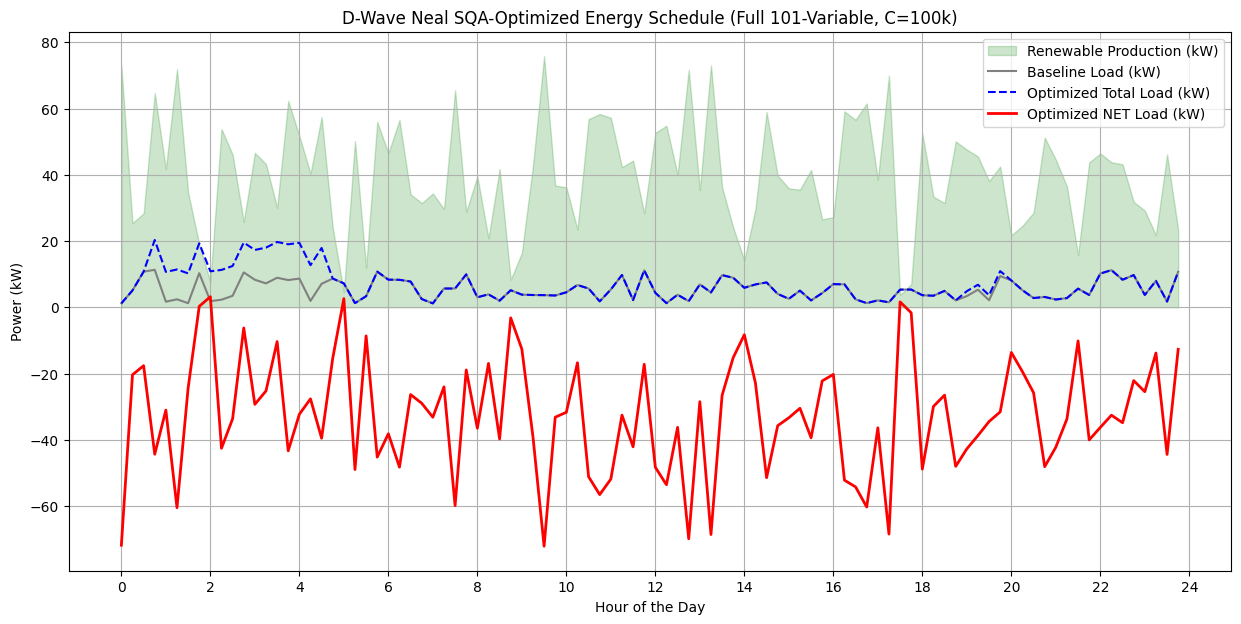

In [6]:
print("\n Phase 4: Analyze and Visualize Results \n")

# --- 18. Validate and Decode the Solution ---
schedule = {
    'ev_charger': {'start': -1, 'P': 9.0, 'L': 16},
    'washing_machine': {'start': -1, 'P': 1.5, 'L': 4},
    'dishwasher': {'start': -1, 'P': 1.8, 'L': 6}
}
total_cost = 0.0
valid_schedule = True
app_counts = {'ev_charger': 0, 'washing_machine': 0, 'dishwasher': 0}

# --- Validation Step ---
# First, count the 'on' bits for each appliance
for var_idx, bit in best_solution.items():
    if bit == 1:
        app_name, start_time = reverse_map[var_idx]
        app_counts[app_name] += 1

# Check if any constraint was broken
for app_name, count in app_counts.items():
    if count != 1:
        print(f"ERROR: Constraint broken for {app_name}! Found {count} start times.")
        valid_schedule = False

# --- Decoding Step ---
if valid_schedule:
    print("Solution is VALID. Decoding schedule...")
    for var_idx, bit in best_solution.items():
        if bit == 1:
            app_name, start_time = reverse_map[var_idx]
            schedule[app_name]['start'] = start_time
            
            # Calculate cost of this run
            app = appliances[app_name]
            P, L = app['P'], app['L']
            cost_of_run = sum(C_t[t % T] for t in range(start_time, start_time + L))
            total_cost += P * cost_of_run
else:
    print("ERROR: Solution is INVALID. The schedule below will be empty or incomplete.")
    print("Try increasing the penalty 'C' in Phase 2 even more.")

print("\n Optimized Schedule \n")
for app_name, details in schedule.items():
    if details['start'] != -1:
        print(f"  {app_name}: Start at time step {details['start']}")
    else:
        print(f"  {app_name}: NOT SCHEDULED")
        
print(f"Total deferrable cost: ${total_cost:.2f}")


# --- 19. Build Final Load Profile ---
optimized_load = np.zeros(T)
for app_name, details in schedule.items():
    if details['start'] != -1:
        start = details['start']
        L = details['L']
        P = details['P']
        for t_i in range(start, start + L):
            optimized_load[t_i % T] += P

# --- 20. Plot Final Visualization (Same as original) ---
print("Generating final schedule plot...")
time_axis = np.arange(T) * 0.25 # Time in hours

plt.figure(figsize=(15, 7))
plt.fill_between(time_axis, R_t, label="Renewable Production (kW)", color='green', alpha=0.2)
plt.plot(time_axis, B_t, label="Baseline Load (kW)", color='grey')
plt.plot(time_axis, B_t + optimized_load, label="Optimized Total Load (kW)", color='blue', linestyle='--')
plt.plot(time_axis, B_t + optimized_load - R_t, label="Optimized NET Load (kW)", color='red', linewidth=2)

plt.xlabel("Hour of the Day")
plt.ylabel("Power (kW)")
plt.title("D-Wave Neal SQA-Optimized Energy Schedule (Full 101-Variable, C=100k)") #<-- updated title
plt.xticks(ticks=range(0, 25, 2))
plt.legend()
plt.grid(True)
plt.savefig("qaoa_neal_final_schedule_full_v2.png") #<-- updated filename

print("Saved final schedule plot to 'qaoa_neal_final_schedule_full_v2.png'")
print("Phase 4 Complete \n")

# Independent Per-Appliance Optimization

Instead of a single, large QUBO for all appliances:
$$H_{total} = A \cdot H_{cost} + B \cdot H_{peak} + C \cdot H_{constraint}$$

We solve separate QUBOs for each appliance:

- **EV:** $$H^{ev} = A \cdot H_{cost}^{ev} + C \cdot H_{constraint}^{ev}$$
- **Washer:** $$H^{washer} = A \cdot H_{cost}^{washer} + C \cdot H_{constraint}^{washer}$$
- **Dishwasher:** $$H^{dish} = A \cdot H_{cost}^{dish} + C \cdot H_{constraint}^{dish}$$

The key difference is the omission of the \( B \cdot H_{peak} \) term. This means the appliances do not coordinate to reduce peak demand.

**Crucially, the missing \( H_{peak} \) term is defined as:**
$$H_{peak} = B \cdot \sum_t \left( (B_t + L_{deferrable}(t) - R_t)^2 \right)$$
where \( L_{deferrable}(t) = \sum_i (P_i \cdot x_i) \) **is the sum over all appliances.**

Therefore, without this cross-appliance interaction, each appliance's schedule is determined independently and does not account for:
- Other appliances' schedules,
- Their collective impact on the total load, or
- The penalty for simultaneous operation.

In [11]:
print("\n Independent Per-Appliance Optimization (Same Structure) \n")

# --- Use the EXACT same variable mapping as before ---
# We'll reuse: var_map, reverse_map, n_vars from Phase 2

independent_schedule = {}
independent_total_cost = 0.0

for app_name in appliances.keys():
    print(f"Optimizing {app_name} independently...")
    
    # --- Build QUBO for this appliance ONLY ---
    Q_appliance = {}
    offset_appliance = 0.0
    
    # 1. H_cost_term (EXACT same as original)
    for (app, start_time), var_idx in var_map.items():
        if app == app_name:  # ONLY include this appliance
            app_details = appliances[app_name]
            P = app_details['P']
            L = app_details['L']
            
            cost_of_run = 0.0
            for t in range(start_time, start_time + L):
                cost_of_run += C_t[t % T]
            C_i_t = P * cost_of_run
            
            Q_key = (var_idx, var_idx)
            Q_appliance[Q_key] = Q_appliance.get(Q_key, 0.0) + (A * C_i_t)

    # 2. H_constraint_term (EXACT same as original, but for one appliance)
    app_details = appliances[app_name]
    app_vars = [var_map[(app_name, t)] for t in app_details['window']]
    
    # Constant offset
    offset_appliance += C
    
    # Linear terms
    for var_idx in app_vars:
        Q_key = (var_idx, var_idx)
        Q_appliance[Q_key] = Q_appliance.get(Q_key, 0.0) - C
        
    # Quadratic terms  
    for i in range(len(app_vars)):
        for j in range(i + 1, len(app_vars)):
            q_i = app_vars[i]
            q_j = app_vars[j]
            Q_key = tuple(sorted((q_i, q_j)))
            Q_appliance[Q_key] = Q_appliance.get(Q_key, 0.0) + (2 * C)

    # 3. NO H_peak_term - this is the key difference!
    # In global optimization we had:
    # for t in range(T): ... (peak calculations with ALL appliances)
    # In independent: we SKIP this entirely
    
    # --- Solve (EXACT same as original) ---
    sampleset = sampler.sample_qubo(Q_appliance, num_reads=50)
    best_solution = sampleset.first.sample
    
    # --- Decode (EXACT same structure as original) ---
    selected_start = None
    for var_idx, bit in best_solution.items():
        if bit == 1:
            app, start_time = reverse_map[var_idx]
            if app == app_name:
                selected_start = start_time
                break
    
    if selected_start is not None:
        independent_schedule[app_name] = {
            'start': selected_start, 
            'P': appliances[app_name]['P'], 
            'L': appliances[app_name]['L']
        }
        
        # Calculate cost (same as original)
        cost_of_run = 0.0
        for t in range(selected_start, selected_start + appliances[app_name]['L']):
            cost_of_run += C_t[t % T]
        appliance_cost = appliances[app_name]['P'] * cost_of_run
        independent_total_cost += appliance_cost
        
        print(f"  {app_name}: Start at step {selected_start}, Cost: ${appliance_cost:.2f}")
    else:
        print(f"  ERROR: {app_name} - no start time selected!")

print(f"\nIndependent Optimization Complete!")
print(f"Total Cost: ${independent_total_cost:.2f}")

# --- Build load profile (EXACT same as original) ---
independent_load = np.zeros(T)
for app_name, details in independent_schedule.items():
    if details['start'] != -1:
        start = details['start']
        L = details['L']
        P = details['P']
        for t_i in range(start, start + L):
            independent_load[t_i % T] += P

# --- Compare with global results ---
print("\n" + "="*50)
print("SCHEDULE COMPARISON")
print("="*50)

print("Global Optimization Schedule:")
for app_name in appliances.keys():
    if schedule[app_name]['start'] != -1:
        print(f"  {app_name}: step {schedule[app_name]['start']}")
    else:
        print(f"  {app_name}: NOT SCHEDULED")

print("\nIndependent Optimization Schedule:")  
for app_name in appliances.keys():
    if app_name in independent_schedule and independent_schedule[app_name]['start'] != -1:
        print(f"  {app_name}: step {independent_schedule[app_name]['start']}")
    else:
        print(f"  {app_name}: NOT SCHEDULED")

# Check for overlaps
print("\nOverlap Analysis:")
for t in range(T):
    appliances_running = []
    for app_name, details in independent_schedule.items():
        if details['start'] != -1:
            start, L = details['start'], details['L']
            if any(t % T == (start + offset) % T for offset in range(L)):
                appliances_running.append(app_name)
    
    if len(appliances_running) > 1:
        print(f"  Step {t}: {', '.join(appliances_running)}")


 Independent Per-Appliance Optimization (Same Structure) 

Optimizing ev_charger independently...
  ev_charger: Start at step 7, Cost: $46.14
Optimizing washing_machine independently...
  washing_machine: Start at step 81, Cost: $1.35
Optimizing dishwasher independently...
  dishwasher: Start at step 9, Cost: $3.00

Independent Optimization Complete!
Total Cost: $50.48

SCHEDULE COMPARISON
Global Optimization Schedule:
  ev_charger: step 3
  washing_machine: step 76
  dishwasher: step 13

Independent Optimization Schedule:
  ev_charger: step 7
  washing_machine: step 81
  dishwasher: step 9

Overlap Analysis:
  Step 9: ev_charger, dishwasher
  Step 10: ev_charger, dishwasher
  Step 11: ev_charger, dishwasher
  Step 12: ev_charger, dishwasher
  Step 13: ev_charger, dishwasher
  Step 14: ev_charger, dishwasher



Generating comparison plot...


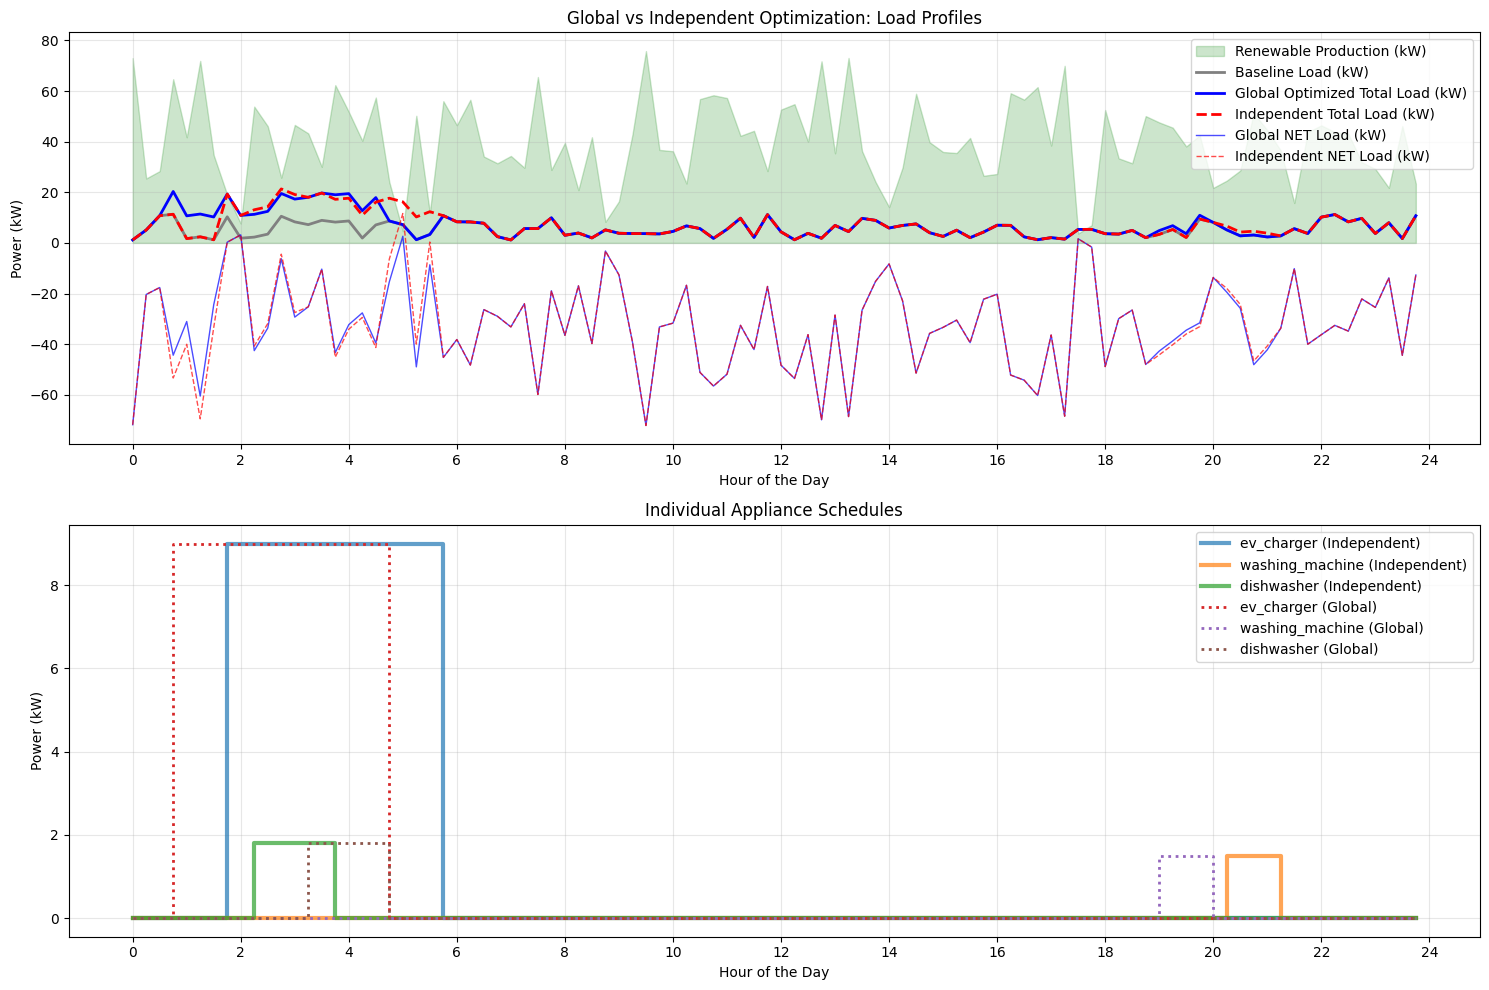

Saved comparison plot to 'independent_vs_global_comparison.png'

PERFORMANCE COMPARISON
Metric                    Global       Independent  Difference  
------------------------------------------------------------
Total Cost ($)            $55.57       $50.48       $-5.08
Peak Net Load (kW)        3.18        11.63       +8.44
Avg Net Load (kW)         -32.73      -32.73      +0.00

Overlap Analysis:
  Time steps with appliance overlaps: 6/96 (6.2%)
  Maximum simultaneous appliances: 2

Independent Optimization Analysis Complete!


In [12]:
# --- Plot Comparison (Same as original style) ---
print("\nGenerating comparison plot...")

# Calculate net loads for both approaches
global_net_load = B_t + optimized_load - R_t
independent_net_load = B_t + independent_load - R_t

# Create time axis (same as original)
time_axis = np.arange(T) * 0.25  # Time in hours

plt.figure(figsize=(15, 10))

# Plot 1: Overall comparison (similar to your original plot)
plt.subplot(2, 1, 1)
plt.fill_between(time_axis, R_t, label="Renewable Production (kW)", color='green', alpha=0.2)
plt.plot(time_axis, B_t, label="Baseline Load (kW)", color='grey', linewidth=2)
plt.plot(time_axis, B_t + optimized_load, label="Global Optimized Total Load (kW)", color='blue', linestyle='-', linewidth=2)
plt.plot(time_axis, B_t + independent_load, label="Independent Total Load (kW)", color='red', linestyle='--', linewidth=2)
plt.plot(time_axis, global_net_load, label="Global NET Load (kW)", color='blue', linestyle='-', linewidth=1, alpha=0.7)
plt.plot(time_axis, independent_net_load, label="Independent NET Load (kW)", color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.xlabel("Hour of the Day")
plt.ylabel("Power (kW)")
plt.title("Global vs Independent Optimization: Load Profiles")
plt.xticks(ticks=range(0, 25, 2))
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Individual appliance schedules
plt.subplot(2, 1, 2)

# Plot independent schedules
for app_name, details in independent_schedule.items():
    if details['start'] != -1:
        start, L, P = details['start'], details['L'], details['P']
        app_load = np.zeros(T)
        for t_i in range(start, start + L):
            app_load[t_i % T] = P  # Show constant power during operation
        plt.step(time_axis, app_load, where='post', label=f"{app_name} (Independent)", linewidth=3, alpha=0.7)

# Plot global schedules  
for app_name, details in schedule.items():
    if details['start'] != -1:
        start, L, P = details['start'], details['L'], details['P']
        app_load = np.zeros(T)
        for t_i in range(start, start + L):
            app_load[t_i % T] = P
        plt.step(time_axis, app_load, where='post', label=f"{app_name} (Global)", linestyle=':', linewidth=2)

plt.xlabel("Hour of the Day")
plt.ylabel("Power (kW)")
plt.title("Individual Appliance Schedules")
plt.xticks(ticks=range(0, 25, 2))
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("independent_vs_global_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved comparison plot to 'independent_vs_global_comparison.png'")

# --- Performance Metrics (Numerical Comparison) ---
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

global_peak = global_net_load.max()
independent_peak = independent_net_load.max()
peak_reduction = independent_peak - global_peak

global_cost = total_cost
cost_difference = independent_total_cost - global_cost

print(f"{'Metric':<25} {'Global':<12} {'Independent':<12} {'Difference':<12}")
print(f"{'-'*60}")
print(f"{'Total Cost ($)':<25} ${global_cost:<11.2f} ${independent_total_cost:<11.2f} ${cost_difference:+.2f}")
print(f"{'Peak Net Load (kW)':<25} {global_peak:<11.2f} {independent_peak:<11.2f} {peak_reduction:+.2f}")
print(f"{'Avg Net Load (kW)':<25} {global_net_load.mean():<11.2f} {independent_net_load.mean():<11.2f} {independent_net_load.mean() - global_net_load.mean():+.2f}")

# Count overlapping periods
overlap_count = 0
max_simultaneous = 0
for t in range(T):
    simultaneous_count = 0
    for app_name, details in independent_schedule.items():
        if details['start'] != -1:
            start, L = details['start'], details['L']
            if any(t % T == (start + offset) % T for offset in range(L)):
                simultaneous_count += 1
    if simultaneous_count > 1:
        overlap_count += 1
    if simultaneous_count > max_simultaneous:
        max_simultaneous = simultaneous_count

print(f"\nOverlap Analysis:")
print(f"  Time steps with appliance overlaps: {overlap_count}/96 ({overlap_count/96*100:.1f}%)")
print(f"  Maximum simultaneous appliances: {max_simultaneous}")

print("\nIndependent Optimization Analysis Complete!")

# Hyperparameters dependency

In the previous section, we used the hyperparameter set A=0.5, B=3.0, C=100,000.0. This set was identified through a hyperparameter study, described below, with the goal of minimizing total energy consumption.

To perform this study, we tested the following values:
- **A:** [0.5, 1.0, 2.0]
- **B:** [0.5, 1.5, 3.0]
- **C:** [5000.0, 50000.0, 100000.0]

In [9]:
# ...existing code...
# Add: hyperparameter sweep driver (paste as a new cell after Phase 3)
import pandas as pd
import time
from itertools import product

def build_qubo_for_hyperparameters(A, B, C_penalty):
    # Rebuild Q and offset using current workspace variables (appliances, var_map, C_t, B_t, R_t, T)
    Q_local = {}
    offset_local = 0.0

    # H_cost
    for (app_name, start_time), var_idx in var_map.items():
        app = appliances[app_name]
        P = app['P']
        L = app['L']
        cost_of_run = 0.0
        for t in range(start_time, start_time + L):
            cost_of_run += C_t[t % T]
        C_i_t = P * cost_of_run
        Q_key = (var_idx, var_idx)
        Q_local[Q_key] = Q_local.get(Q_key, 0.0) + (A * C_i_t)

    # H_constraint (exactly-one per appliance) with penalty C_penalty
    for app_name, app_details in appliances.items():
        app_vars = [var_map[(app_name, t)] for t in app_details['window']]
        offset_local += C_penalty
        for var_idx in app_vars:
            Q_key = (var_idx, var_idx)
            Q_local[Q_key] = Q_local.get(Q_key, 0.0) - C_penalty
        for i in range(len(app_vars)):
            for j in range(i + 1, len(app_vars)):
                q_i = app_vars[i]
                q_j = app_vars[j]
                Q_key = tuple(sorted((q_i, q_j)))
                Q_local[Q_key] = Q_local.get(Q_key, 0.0) + (2 * C_penalty)

    # H_peak
    for t in range(T):
        net_baseline = B_t[t] - R_t[t]
        offset_local += B * (net_baseline ** 2)
        L_def_terms = []
        for (app_name, start_time), var_idx in var_map.items():
            app = appliances[app_name]
            P = app['P']
            L = app['L']
            is_on = False
            if start_time + L > T:
                if (t >= start_time) or (t < (start_time + L) % T):
                    is_on = True
            else:
                if (t >= start_time) and (t < start_time + L):
                    is_on = True
            if is_on:
                L_def_terms.append((var_idx, P))

        for var_idx, P_i in L_def_terms:
            coeff = B * 2 * net_baseline * P_i
            Q_key = (var_idx, var_idx)
            Q_local[Q_key] = Q_local.get(Q_key, 0.0) + coeff

        for var_idx, P_i in L_def_terms:
            coeff = B * (P_i**2)
            Q_key = (var_idx, var_idx)
            Q_local[Q_key] = Q_local.get(Q_key, 0.0) + coeff

        for i in range(len(L_def_terms)):
            for j in range(i + 1, len(L_def_terms)):
                q_i, P_i = L_def_terms[i]
                q_j, P_j = L_def_terms[j]
                coeff = B * 2 * P_i * P_j
                Q_key = tuple(sorted((q_i, q_j)))
                Q_local[Q_key] = Q_local.get(Q_key, 0.0) + coeff

    return Q_local, offset_local

def evaluate_sample(sample):
    # Decode schedule, compute total deferrable cost and peak net load
    schedule_local = {k: {'start': -1, 'P': v['P'], 'L': v['L']} for k, v in appliances.items()}
    app_counts_local = {k: 0 for k in appliances.keys()}
    total_cost_local = 0.0

    for var_idx, bit in sample.items():
        if bit == 1:
            app_name, start_time = reverse_map[var_idx]
            app_counts_local[app_name] += 1

    feasible = all(count == 1 for count in app_counts_local.values())
    if feasible:
        for var_idx, bit in sample.items():
            if bit == 1:
                app_name, start_time = reverse_map[var_idx]
                schedule_local[app_name]['start'] = start_time
                app = appliances[app_name]
                P, L = app['P'], app['L']
                cost_of_run = sum(C_t[t % T] for t in range(start_time, start_time + L))
                total_cost_local += P * cost_of_run

    # Build optimized_load regardless (feasible or not) from scheduled starts
    optimized_load_local = np.zeros(T)
    for app_name, details in schedule_local.items():
        if details['start'] != -1:
            start = details['start']
            L = details['L']
            P = details['P']
            for t_i in range(start, start + L):
                optimized_load_local[t_i % T] += P

    net_load = B_t + optimized_load_local - R_t
    peak_net = float(np.max(net_load))

    return {
        'feasible': feasible,
        'total_cost': float(total_cost_local),
        'peak_net_load': peak_net,
        'optimized_load': optimized_load_local
    }

# Sweep configuration (edit lists as desired)
A_values = [0.5, 1.0, 2.0]
B_values = [0.5, 1.5, 3.0]
C_values = [5000.0, 50000.0, 100000.0]
num_reads = 100

results = []
sampler_local = sampler  # reuse existing sampler

for A_val, B_val, C_val in product(A_values, B_values, C_values):
    print(f"Running sweep A={A_val}, B={B_val}, C={C_val} ...")
    start_build = time.time()
    Q_sweep, offset_sweep = build_qubo_for_hyperparameters(A_val, B_val, C_val)
    build_time = time.time() - start_build

    start_sample = time.time()
    sampleset = sampler_local.sample_qubo(Q_sweep, num_reads=num_reads)
    sample_time = time.time() - start_sample

    best = sampleset.first
    sample_dict = best.sample
    energy = float(best.energy)

    eval_res = evaluate_sample(sample_dict)
    results.append({
        'A': A_val,
        'B': B_val,
        'C': C_val,
        'build_time_s': build_time,
        'sample_time_s': sample_time,
        'energy': energy,
        'energy_with_offset': energy + offset_sweep,
        'feasible': eval_res['feasible'],
        'total_cost': eval_res['total_cost'],
        'peak_net_load': eval_res['peak_net_load']
    })

df_results = pd.DataFrame(results)
df_results.to_csv("hyperparam_sweep_results.csv", index=False)
print("Saved sweep results to 'hyperparam_sweep_results.csv'")
# ...existing code...

Running sweep A=0.5, B=0.5, C=5000.0 ...
Running sweep A=0.5, B=0.5, C=50000.0 ...
Running sweep A=0.5, B=0.5, C=100000.0 ...
Running sweep A=0.5, B=1.5, C=5000.0 ...
Running sweep A=0.5, B=1.5, C=50000.0 ...
Running sweep A=0.5, B=1.5, C=100000.0 ...
Running sweep A=0.5, B=3.0, C=5000.0 ...
Running sweep A=0.5, B=3.0, C=50000.0 ...
Running sweep A=0.5, B=3.0, C=100000.0 ...
Running sweep A=1.0, B=0.5, C=5000.0 ...
Running sweep A=1.0, B=0.5, C=50000.0 ...
Running sweep A=1.0, B=0.5, C=100000.0 ...
Running sweep A=1.0, B=1.5, C=5000.0 ...
Running sweep A=1.0, B=1.5, C=50000.0 ...
Running sweep A=1.0, B=1.5, C=100000.0 ...
Running sweep A=1.0, B=3.0, C=5000.0 ...
Running sweep A=1.0, B=3.0, C=50000.0 ...
Running sweep A=1.0, B=3.0, C=100000.0 ...
Running sweep A=2.0, B=0.5, C=5000.0 ...
Running sweep A=2.0, B=0.5, C=50000.0 ...
Running sweep A=2.0, B=0.5, C=100000.0 ...
Running sweep A=2.0, B=1.5, C=5000.0 ...
Running sweep A=2.0, B=1.5, C=50000.0 ...
Running sweep A=2.0, B=1.5, C=10000

In [12]:
# Load and analyze the sweep results
df = pd.read_csv("hyperparam_sweep_results.csv")

# Filter for feasible solutions first
feasible_df = df[df['feasible']]

# Find minimum energy solution for each parameter A, B, C
print("\nMinimum Energy Solutions by Parameter:")

print("\nBy A value:")
for a in A_values:
    a_sols = feasible_df[feasible_df['A'] == a]
    if not a_sols.empty:
        min_e_row = a_sols.loc[a_sols['energy'].idxmin()]
        print(f"A={a:.1f}: Energy={min_e_row['energy']:.2f}, B={min_e_row['B']}, C={min_e_row['C']}")
        print(f"  Cost=${min_e_row['total_cost']:.2f}, Peak={min_e_row['peak_net_load']:.2f}kW")

print("\nBy B value:")
for b in B_values:
    b_sols = feasible_df[feasible_df['B'] == b]
    if not b_sols.empty:
        min_e_row = b_sols.loc[b_sols['energy'].idxmin()]
        print(f"B={b:.1f}: Energy={min_e_row['energy']:.2f}, A={min_e_row['A']}, C={min_e_row['C']}")
        print(f"  Cost=${min_e_row['total_cost']:.2f}, Peak={min_e_row['peak_net_load']:.2f}kW")

print("\nBy C value:")
for c in C_values:
    c_sols = feasible_df[feasible_df['C'] == c]
    if not c_sols.empty:
        min_e_row = c_sols.loc[c_sols['energy'].idxmin()]
        print(f"C={c:.1f}: Energy={min_e_row['energy']:.2f}, A={min_e_row['A']}, B={min_e_row['B']}")
        print(f"  Cost=${min_e_row['total_cost']:.2f}, Peak={min_e_row['peak_net_load']:.2f}kW")

# Overall minimum energy solution
min_energy_row = feasible_df.loc[feasible_df['energy'].idxmin()]
print("\nOverall minimum energy solution:")
print(f"A={min_energy_row['A']}, B={min_energy_row['B']}, C={min_energy_row['C']}")
print(f"Energy={min_energy_row['energy']:.2f}")
print(f"Total Cost=${min_energy_row['total_cost']:.2f}")
print(f"Peak Net Load={min_energy_row['peak_net_load']:.2f}kW")




Minimum Energy Solutions by Parameter:

By A value:
A=0.5: Energy=-331928.90, B=3.0, C=100000.0
  Cost=$55.31, Peak=3.18kW
A=1.0: Energy=-331816.07, B=3.0, C=100000.0
  Cost=$55.31, Peak=3.18kW
A=2.0: Energy=-331711.62, B=3.0, C=100000.0
  Cost=$55.19, Peak=3.18kW

By B value:
B=0.5: Energy=-305296.87, A=0.5, C=100000.0
  Cost=$55.57, Peak=3.18kW
B=1.5: Energy=-315985.56, A=1.0, C=100000.0
  Cost=$55.70, Peak=3.18kW
B=3.0: Energy=-331928.90, A=0.5, C=100000.0
  Cost=$55.31, Peak=3.18kW

By C value:
C=5000.0: Energy=-20296.87, A=0.5, B=0.5
  Cost=$55.57, Peak=3.18kW
C=50000.0: Energy=-181920.17, A=0.5, B=3.0
  Cost=$55.57, Peak=3.18kW
C=100000.0: Energy=-331928.90, A=0.5, B=3.0
  Cost=$55.31, Peak=3.18kW

Overall minimum energy solution:
A=0.5, B=3.0, C=100000.0
Energy=-331928.90
Total Cost=$55.31
Peak Net Load=3.18kW


We can see the minimum energy does not always happens in the same time as the mimimum total cost because mathematically the QUBO energy includes electricity cost, peak penalty, and constraint satisfaction whereas the QUBO electricity bill includes only the actual money spent on electricity.

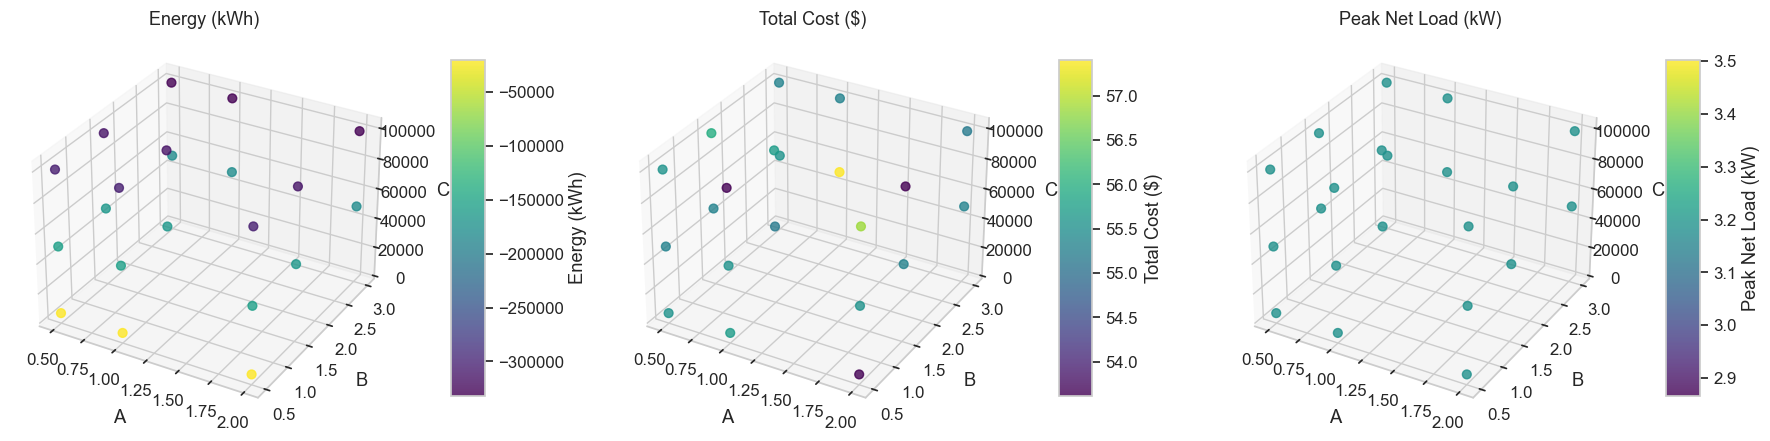

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# Load and filter
df = pd.read_csv("hyperparam_sweep_results.csv")
feasible_df = df[df['feasible']]

# Define metrics and titles
metrics = ['energy', 'total_cost', 'peak_net_load']
titles = ['Energy (kWh)', 'Total Cost ($)', 'Peak Net Load (kW)']

# Create a 3D subplot figure
fig = plt.figure(figsize=(18, 6))

for i, (metric, title) in enumerate(zip(metrics, titles), 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    sc = ax.scatter(
        feasible_df['A'],
        feasible_df['B'],
        feasible_df['C'],
        c=feasible_df[metric],
        cmap='viridis',
        s=40,
        alpha=0.8
    )
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('A', labelpad=8)
    ax.set_ylabel('B', labelpad=8)
    ax.set_zlabel('C', labelpad=8)
    fig.colorbar(sc, ax=ax, shrink=0.6, aspect=10, pad=0.1, label=title)

plt.tight_layout()
plt.show()


We try to present the 3D volume of the energy, total cost, and peak net load using interpolation techniques.

In [13]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata
from concurrent.futures import ThreadPoolExecutor

# Load data
df = pd.read_csv("hyperparam_sweep_results.csv")
feasible_df = df[df['feasible']]

x = feasible_df['A'].values
y = feasible_df['B'].values
z = feasible_df['C'].values
energy = feasible_df['energy'].values
cost = feasible_df['total_cost'].values
peak = feasible_df['peak_net_load'].values


In [14]:
grid_size = 30
A_grid = np.linspace(x.min(), x.max(), grid_size)
B_grid = np.linspace(y.min(), y.max(), grid_size)
C_grid = np.linspace(z.min(), z.max(), grid_size)
A_mesh, B_mesh, C_mesh = np.meshgrid(A_grid, B_grid, C_grid, indexing='ij')


To interpolate it, we use `'linear'` + fallback to `'nearest'` methods. `'linear'` interpolation will work well inside the region covered by your data.
Outside that region, you’ll get `NaN` (no extrapolation). `'nearest'` will all space but produce rougher transitions.

In [15]:
def interpolate_3d(values):
    def interpolate_slice(c_idx):
        xi = np.column_stack((
            A_mesh[:, :, c_idx].ravel(),
            B_mesh[:, :, c_idx].ravel(),
            np.full(A_mesh[:, :, c_idx].size, C_grid[c_idx])
        ))
        points = np.column_stack((x, y, z))

        # Linear interpolation
        slice_values = griddata(points, values, xi, method='linear')

        # Fill NaNs with nearest
        mask = np.isnan(slice_values)
        if mask.any():
            slice_values[mask] = griddata(points, values, xi[mask], method='nearest')

        return slice_values.reshape(A_mesh.shape[0], A_mesh.shape[1])

    with ThreadPoolExecutor(max_workers=4) as executor:
        slices = list(executor.map(interpolate_slice, range(len(C_grid))))
    return np.stack(slices, axis=2)


In [16]:
E_grid = interpolate_3d(energy)
C_grid_vals = interpolate_3d(cost)
P_grid = interpolate_3d(peak)


In [17]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=('Energy', 'Total Cost', 'Peak Net Load')
)


In [18]:
# Energy
fig.add_trace(go.Volume(
    x=A_mesh.flatten(),
    y=B_mesh.flatten(),
    z=C_mesh.flatten(),
    value=E_grid.flatten(),
    isomin=np.nanmin(energy),
    isomax=np.nanmax(energy),
    opacity=0.2,
    surface_count=20,
    colorscale='Plasma',
    colorbar=dict(
        title='Energy (kWh)',
        x=0.26,    # shift left
        y=0.85,
        len=0.5,        # shrink height
        thickness=12,   # make thinner
        ),
    ), row=1, col=1)

# Cost
fig.add_trace(go.Volume(
    x=A_mesh.flatten(),
    y=B_mesh.flatten(),
    z=C_mesh.flatten(),
    value=C_grid_vals.flatten(),
    isomin=np.nanmin(cost),
    isomax=np.nanmax(cost),
    opacity=0.2,
    surface_count=20,
    colorscale='Plasma',
    colorbar=dict(
        title='Total Cost ($)',
        x=0.62,    # center
        y=0.85,
        len=0.5,        # shrink height
        thickness=12,   # make thinner
        ),
    ), row=1, col=2)

# Peak
fig.add_trace(go.Volume(
    x=A_mesh.flatten(),
    y=B_mesh.flatten(),
    z=C_mesh.flatten(),
    value=P_grid.flatten(),
    isomin=np.nanmin(peak),
    isomax=np.nanmax(peak),
    opacity=0.2,
    surface_count=20,
    colorscale='Plasma',
    colorbar=dict(
        title='Peak Net Load (kW)',
        x=0.97,     # rightmost
        y=0.85,
        len=0.5,        # shrink height
        thickness=12,   # make thinner
    ),
), row=1, col=3)
